<img src="images/chlalogo.jpg" width="500">

# Keras(Theano)による時系列データモデリング

電子健康記録（EHR）には、患者の医療情報が豊富に含まれています。これにより、緊急事態が起きたときの貴重な時間を節約したり、不要な治療や検査を排除したり、命に関わるミスを防いだり、医療支援を求める患者に対するケアの全体的な質を高めたりすることができます。
ロサンゼルス小児病院（CHLA）は、余分なケアや重症度の指標を必要とする患者の初期徴候を得るために、記録が取れるかどうかを知りたがっていました。
 このラボでは、約5000人の小児ICU患者のEHRにディープニューラルネットワークを適用した、CHLAによる研究結果に迫っていきます。

ここではディープラーニングを用いて、医療専門家がいつでも患者の死亡率を解析できるようなフレームワークを提供します。
これにより、忙しい病院環境で治療決定の影響を評価したり、リスクの高い患者の初期徴候を引き上げたりする際の重要なフィードバックを臨床医に与えることができるのです。

このラボでは、Pythonのライブラリである[```pandas```](http://pandas.pydata.org)を使って、[HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)で提供されるデータセットを管理します。そして、ディープラーニングライブラリである[```Keras```](https://keras.io)を使ってリカレントニューラルネットワークを構築します。
ここでは特に、長短期記憶ネットワーク（[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)）と呼ばれる特殊なディープリカレントニューラルネットワークを構築します。
最後には、PIM2やPIM3といった標準的な死亡指数を用いて、このLSTMのパフォーマンスをロジスティック回帰など他の手法と比較します。

## Process
このラボでは、以下のステップを通してCHLAのワークフローを示します。
これらは、あなたが自身のデータにディープニューラルネットワークを適用したいときの手順でもあります。
ただしこれらの手順は、絶対的なアプローチではありません。プロジェクト毎にアプローチは異なります。


1. セットアップ

   A. Theanoのオプション設定

   B. Numpy、Pandas、Matplotlibのインポート

   C. 学習/テストデータを格納するフォルダの定義

   D. Pandas API によるデータの読み込み
<br>
<br>
2. データの準備

   A. データの概観
   
   B. データの正規化

   C. データの補間

   D. データ長の統一
<br>
<br>
3. KerasとTheanoによるLSTMネットワークの設計
<br>
<br>
4. モデルのビルド（学習用データを流し込む）
<br>
<br>
5. 検証（テスト）データによるモデルの評価
<br>
<br>
6. 結果の可視化
<br>
<br>
7. PRISM3、PIM2との比較


## はじめに
最初にすべきことは、Pythonライブラリのインポートです。数値計算のためのNumpy、データ管理のためのpandas、可視化のためのMatplotlib、そしてLSTMネットワーク構築のためのKerasをインポートします。これらの詳細についてはすぐに説明します。

In [1]:
# configure Theano options
import os


In [2]:
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random

# configure notebook to display plots
%matplotlib inline

次に、HDF5形式で保存された学習データとテストデータを格納しておくフォルダを定義します。
このフォルダを用いて、入力（X）と対応するラベル（y）へのファイルパスを定義します。
[HDF5](http://www.hdfgroup.org/)は階層データ形式（Hierarchical Data Format）のバージョン5 を表しています。
HDF形式は、大量の科学データを保存、整理するために特別に設計されたもので、もともとは[米国立スーパーコンピュータ応用研究所](https://en.wikipedia.org/wiki/National_Center_for_Supercomputing_Applications)によるものです。
一般的なファイル拡張子は、```.hdf```、```.hdf5```、あるいは単に```.h5```です。
HDF形式はかなり普及しており、よく整備されています。
そのため、HDF5はほとんどの言語でAPIをサポートしており、Windows、OS X、Linuxでの互換性も持つ柔軟で堅牢なフォーマットだといえます。
ただ、HDFはバイナリ形式のため、テキストベースのCSVのような可読性に欠けている点に注意してください。
とはいえHDF形式は、性能の点でははるかに高速で、ストレージサイズが効率的であり、小さい概念的なアイデアから[巨大な運用プロジェクト](https://www.hdfgroup.org/eos_vignette/)までスケールすることができます。

In [3]:
# set up user paths
data_dir = './data'

# training data inputs: x and targets: y
x_train_path = os.path.join(data_dir, 'X_train.hdf')
y_train_path = os.path.join(data_dir, 'y_train.hdf')

# validation data inputs: x and targest: y
x_valid_path = os.path.join(data_dir, 'X_test.hdf')
y_valid_path = os.path.join(data_dir, 'y_test.hdf')

最後に、HDFファイルを読み込むための```pandas```APIを用いて、データを読み込みます。
pandasライブラリは、Python言語で使いやすいデータ構造や分析ツールを提供する、オープンソースのBSDライセンスプロジェクトです。
神経科学や、金融、経済、統計、広告、ウェブ分析など、様々な学術及び商用領域で使われています。
このライブラリは、統合されたインデックスによる、データ操作用の高速で効率的なDataFrameオブジェクトと、CSVやテキストファイル、Microsoft Excel、SQLデータベース、高速HDF5フォーマットにメモリ内のデータ構造を書き込むためのツールによって特徴づけられます。
より詳しい内容については、[pandas documentation](http://pandas.pydata.org)で確認してください。

In [28]:
X_train = pd.read_hdf(x_train_path)
y_train = pd.read_hdf(y_train_path)

X_valid = pd.read_hdf(x_valid_path)
y_valid = pd.read_hdf(y_valid_path)

### データ

この電子健康記録（EHR）データベースには、経時的に収集された患者の治療記録が含まれています。
ここで使用するEHRには、ロサンゼルス小児病院の小児集中治療室(PICU)における10年分の患者データが含まれています。これらは[vPICU](http://vpicu.net)というチームによって整理されています。
このデータセットは5000人の患者に対する76693件の観測が含まれています。

<img style="float: right;" src="images/ehr.svg" width="450" height="300">
このデータは、患者がPICUにいる間に測定された不規則な時系列データです。
測定の間隔は数分から数時間まで様々です。データの簡略図を右側に示します。測定値には以下のものが含まれています。

* **Statics** *(例： 性別, 年齢, 体重)*
* **Vitals** *(例： 心拍数, 呼吸数)*
* **Labs** *(例： グルコース, クレアチン)*
* **Interventions** *(例： 挿管, 酸素吸入)*
* **Drugs** *(例： ドーパミン, エピネフリン)*

完全な一覧については、[data/ehr_features.csv](data/ehr_features.csv)　を参照してください。

１つ注意しておくべきことは、不均一サンプリングであることに加え、全ての患者に対して全ての測定が行われたわけではないという点です。

学習データを眺めてみると、診察時間ごとに観測された患者とその測定値が見られます。
しかしやはり、全ての測定値が各行に揃っているわけではありません。

そして、ラベル(y)となるのは各患者の最終的な状態です。生存は1、死亡は0で表します。

ではデータの中身を見てみましょう。

In [29]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  \
b'encounterID' b'absoluteTime'                                      
8              0.000000                             NaN       NaN   
               0.250000                             NaN       NaN   
               0.500000                             NaN       NaN   
               0.583333                             NaN       NaN   
               0.750000                             NaN       NaN   
               1.383333                             NaN       NaN   
               1.750000                             NaN       NaN   
               2.250000                             NaN       NaN   
               2.500000                             NaN       NaN   
               2.750000                             NaN       NaN   
               3.583333                             NaN       NaN   
               3.750000                             NaN       NaN   
               4.750000                             NaN       NaN   
               5.083333                             NaN       NaN   
               5.250000                             NaN       NaN   
               5.416667                             NaN       NaN   
               5.750000                             NaN       NaN   
               6.750000                             NaN       NaN   
               6.850000                             NaN       NaN   
               7.583333                             NaN       NaN   
               7.750000                             NaN       NaN   
               8.250000                             NaN       NaN   
               8.750000                             NaN       NaN   
               8.816667                             NaN       NaN   
               9.750000                             NaN       NaN   
               10.750000                            NaN       NaN   
               10.766666                            NaN       NaN   
               11.016666                            NaN       NaN   
               11.750000                            NaN       NaN   
               12.750000                            NaN       NaN   
...                                                 ...       ...   
16259          74.000000                            NaN       NaN   
               74.500000                            NaN       NaN   
               75.000000                            NaN       NaN   
               75.199997                            NaN       NaN   
               75.583336                            NaN       NaN   
               76.000000                            NaN       NaN   
               77.000000                            NaN       NaN   
               78.000000                            NaN       NaN   
               79.000000                            NaN       NaN   
               79.666664                            NaN       NaN   
               80.000000                            NaN       NaN   
               80.066666                            NaN       NaN   
               80.083336                            NaN       NaN   
               80.500000                            NaN       NaN   
               81.000000                            NaN       NaN   
               82.000000                            NaN       NaN   
               83.000000                            NaN       NaN   
               83.250000                            NaN       NaN   
               83.383331                            6.2       NaN   
               83.466667                            NaN       NaN   
               84.000000                            NaN       NaN   
               85.000000                            NaN       NaN   
               85.083336                            NaN       NaN   
               85.466667                            NaN       NaN   
               86.000000                            NaN       NaN   
               87.000000      

ここには、1行あたり265の変数が含まれています。```len(X_train.columns)```を用いることで、直接的にその数を調べることもできます。

注：使用しているオブジェクトの型が不明な場合は、```type```を使いましょう。この場合、```X_train```は```pandas```のデータフレームオブジェクトです。データフレームについての詳細は[こちら](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)をご覧ください。

In [30]:
type(X_train)

pandas.core.frame.DataFrame

pandasによって読み込まれたデータはマルチインデックスのデータフレームです。インデックスレベル０は患者の一意な識別子であり、レベル1は最初の測定時を基準とした、各測定の時刻です。これらのデータフレームの操作方法を示すために、さまざまな患者の特定の変数を取り出してみます。例えば、以下のようになります。

In [31]:
# first select a random patient counter (encounter identifier)
eIdx = random.choice(list(X_train.index.levels[0]))

# next specify a few variables to look at
variables = [
    'Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)'
]

# note that the full list of variables can be constructed using
#list(X_train.columns.values)

# have a look at the varibles for the patient
X_train.loc[eIdx, variables]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
b'absoluteTime',,,,,,,,,
0.000000,0.555839,160.0,100.0,5.8,NaN,NaN,21.0,NaN,NaN
0.083333,0.555848,167.0,100.0,6.0,NaN,NaN,29.0,6.0,2.0
0.433333,0.555888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.450000,0.555890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.800000,0.555930,184.0,91.0,NaN,102.0,86.0,48.0,NaN,NaN
1.083333,0.555963,144.0,100.0,5.8,86.0,75.0,42.0,6.0,2.0
1.183333,0.555974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.500000,0.556010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.083333,0.556077,139.0,100.0,NaN,86.0,75.0,35.0,4.0,2.0


次に、患者それぞれについてのラベルデータを見てみましょう。

In [32]:
y_train

mortalityResponse
b'encounterID' b'absoluteTime'                   
8              0.000000                         1
               0.250000                         1
               0.500000                         1
               0.583333                         1
               0.750000                         1
               1.383333                         1
               1.750000                         1
               2.250000                         1
               2.500000                         1
               2.750000                         1
               3.583333                         1
               3.750000                         1
               4.750000                         1
               5.083333                         1
               5.250000                         1
               5.416667                         1
               5.750000                         1
               6.750000                         1
               6.850000                         1
               7.583333                         1
               7.750000                         1
               8.250000                         1
               8.750000                         1
               8.816667                         1
               9.750000                         1
               10.750000                        1
               10.766666                        1
               11.016666                        1
               11.750000                        1
               12.750000                        1
...                                           ...
16259          74.000000                        1
               74.500000                        1
               75.000000                        1
               75.199997                        1
               75.583336                        1
               76.000000                        1
               77.000000                        1
               78.000000                        1
               79.000000                        1
               79.666664                        1
               80.000000                        1
               80.066666                        1
               80.083336                        1
               80.500000                        1
               81.000000                        1
               82.000000                        1
               83.000000                        1
               83.250000                        1
               83.383331                        1
               83.466667                        1
               84.000000                        1
               85.000000                        1
               85.083336                        1
               85.466667                        1
               86.000000                        1
               87.000000                        1
               87.083336                        1
               87.666664                        1
               88.000000                        1
               89.000000                        1

[1113529 rows x 1 columns]

データフレームから```level[0]```を呼び出すことで、患者IDの一意なリストを生成することができます。

In [33]:
eIdx = X_train.index.levels[0];

次に、各患者について繰り返し、観測数を計算します。

In [34]:
nobs = [X_train.loc[ix].index.shape[0] for ix in eIdx]

そして、患者ごとの観測数を表すヒストグラムを作成します。

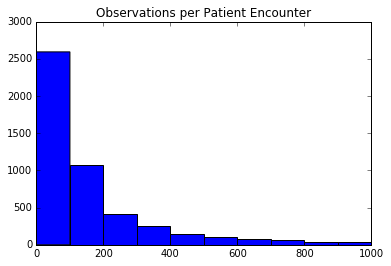

In [35]:
plt.hist(nobs,range=(0,1000))
plt.title("Observations per Patient Encounter")
plt.show()

患者ごとの観測数の平均値（```np.mean(nobs)```で確認できます）は223で、中央値は94です。

同様の分析を行って、全ての患者に対する観測の期間を決められるでしょうか？

In [36]:
# Try here if you'd like

最後に、特定の患者から変数を取り出し、```pandas```のプロット関数を用いてプロットしましょう。

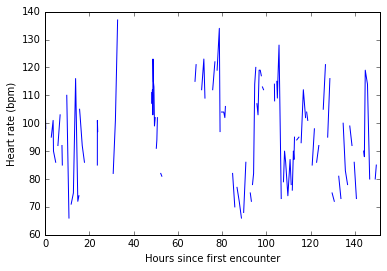

In [37]:
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

これで、データの読み込みと可視化ができたので、モデルを訓練する準備をしましょう。

### データの正規化
ここでは、観測された各特徴および変数から、それらの平均を減算し、標準偏差で割ることによって正規化を行います。

なぜそうするでしょうか？

私たちは、ある変数における小さな変化を、別の変数の大きな変化と同じ重要度で扱うことを望みます。
ネットワークはただ単に、一連の数字を見ているに過ぎないことに留意してください。予測因子や要素、変数、観測などについて、ネットワークが実際に"理解している"わけではありません。
経験的には、正規化がモデルの訓練を容易にすると思われますが、おそらくこの種の正規化は、マルチモーダルなデータ（あるいは一般に正規分布に従わないデータ）に対しては適切ではありません。

これらの変数の分布を確認してみましょう。

In [38]:
# create file path for csv file with metadata about variables
metadata = os.path.join(data_dir, 'ehr_features.csv')

# read in variables from csv file (using pandas) since each varable there is tagged with a category
variables = pd.read_csv(metadata, index_col=0)

# next, select only variables of a particular category for normalization
normvars = variables[variables['type'].isin(['Interventions', 'Labs', 'Vitals'])]

# finally, iterate over each variable in both training and validation data
for vId, dat in normvars.iterrows():
    
    X_train[vId] = X_train[vId] - dat['mean']
    X_valid[vId] = X_valid[vId] - dat['mean']
    X_train[vId] = X_train[vId] / (dat['std'] + 1e-12)
    X_valid[vId] = X_valid[vId] / (dat['std'] + 1e-12)
    

### データの補間
データの正規化は完了しましたが、それぞれの患者について、各時刻に全ての変数が観測されているわけではないので、それらの埋め合わせをする必要があります。
欠落したデータの補間をすることは、研究が非常に活発な分野であり、深層学習を用いた時系列分析における標準的なプラクティスは、現状では存在しません。
このチュートリアルでは以下のように、単純な前方穴埋めを各患者に対して行います。前の測定値が存在しない場合は0で穴埋めします。

<img src="images/imputation_diagram.svg" width="800" height="200">

In [39]:
# first select variables which will be filled in
fillvars = variables[variables['type'].isin(['Vitals', 'Labs'])].index

# next forward fill any missing values with more recently observed value
X_train[fillvars] = X_train.groupby(level=0)[fillvars].ffill()
X_valid[fillvars] = X_valid.groupby(level=0)[fillvars].ffill()

# finally, fill in any still missing values with 0 (i.e. values that could not be filled forward)
X_train.fillna(value=0, inplace=True)
X_valid.fillna(value=0, inplace=True)

データの正規化と補間が行われた後の"心拍数"の変数を、手っ取り早く確認してみましょう。

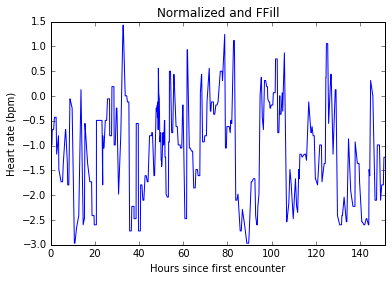

In [40]:
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized and FFill")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

また、X_trainのベクトルを画面に書き出してみると、それらのNaN値がすべて0で埋められているのがわかります。

In [41]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  \
b'encounterID' b'absoluteTime'                                      
8              0.000000                        0.000000  0.000000   
               0.250000                        0.000000  0.000000   
               0.500000                        0.000000  0.000000   
               0.583333                        0.000000  0.000000   
               0.750000                        0.000000  0.000000   
               1.383333                        0.000000  0.000000   
               1.750000                        0.000000  0.000000   
               2.250000                        0.000000  0.000000   
               2.500000                        0.000000  0.000000   
               2.750000                        0.000000  0.000000   
               3.583333                        0.000000  0.000000   
               3.750000                        0.000000  0.000000   
               4.750000                        0.000000  0.000000   
               5.083333                        0.000000  0.000000   
               5.250000                        0.000000  0.000000   
               5.416667                        0.000000  0.000000   
               5.750000                        0.000000  0.000000   
               6.750000                        0.000000  0.000000   
               6.850000                        0.000000  0.000000   
               7.583333                        0.000000  0.000000   
               7.750000                        0.000000  0.000000   
               8.250000                        0.000000  0.000000   
               8.750000                        0.000000  0.000000   
               8.816667                        0.000000  0.000000   
               9.750000                        0.000000  0.000000   
               10.750000                       0.000000  0.000000   
               10.766666                       0.000000  0.000000   
               11.016666                       0.000000  0.000000   
               11.750000                       0.000000  0.000000   
               12.750000                       0.000000  0.000000   
...                                                 ...       ...   
16259          74.000000                       1.538003 -1.770313   
               74.500000                       1.538003 -1.770313   
               75.000000                       1.538003 -1.770313   
               75.199997                       1.538003 -1.770313   
               75.583336                       1.538003 -1.770313   
               76.000000                       1.538003 -1.770313   
               77.000000                       1.538003 -1.770313   
               78.000000                       1.538003 -1.770313   
               79.000000                       1.538003 -1.770313   
               79.666664                       1.538003 -1.770313   
               80.000000                       1.538003 -1.770313   
               80.066666                       1.538003 -1.770313   
               80.083336                       1.538003 -1.770313   
               80.500000                       1.538003 -1.770313   
               81.000000                       1.538003 -1.770313   
               82.000000                       1.538003 -1.770313   
               83.000000                       1.538003 -1.770313   
               83.250000                       1.538003 -1.770313   
               83.383331                       2.335037 -1.770313   
               83.466667                       2.335037 -1.770313   
               84.000000                       2.335037 -1.770313   
               85.000000                       2.335037 -1.770313   
               85.083336                       2.335037 -1.770313   
               85.466667                       2.335037 -1.770313   
               86.000000                       2.335037 -1.770313   
               87.000000      

### データ長の統一
データ準備の最後のタスクは、各患者の観測数が同じになるようにパディングを行うことです。ヒストグラムによると、観測ベクトルが100個未満の患者がかなりいるようです。そのため、各患者に対してゼロパディングを行います（つまり、ゼロの行を挿入します）。

In [42]:
import keras
from keras.preprocessing import sequence

# max number of sequence length
maxlen = 500

# get a list of unique patient encounter IDs
teId = X_train.index.levels[0]
veId = X_valid.index.levels[0]

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [X_train.loc[patient].values for patient in teId]
y_train = [y_train.loc[patient].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [X_valid.loc[patient].values for patient in veId]
y_valid = [y_valid.loc[patient].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

さて、ここでは以下が実行されています:  

1.  ```pandas```のデータフレームを、値のリスト（値のリストのリスト）を含む、Pythonの```list```に変換しました。 
2. ```keras.preprocessing.sequence.pad_sequences``` を使用して、値のリストを```float32```型の```numpy.array```に変換しました。最大長は500としています。 
3. 観測数が500に満たない患者（ヒストグラムによればほとんどの患者が当てはまります）には、```padding='post'```を適用しゼロパディングを行いました。これにより、すべての要素がゼロとなる行（観測ベクトル）が追加されました。
4. ```truncating='post'```オプションによって、観測数が500を超える場合は最初の500を取り、それ以降はすべて削除します。

つまり、患者の記録の次元を500×265にし、必要に応じてサイズを膨らませるためにゼロパディングを使用しているのです。```pandas```でも同様の処理が行なえますが、一つのコマンドではできません。

In [43]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))

X_train shape: (5000, 500, 265) | y_train shape: (5000, 500, 1)
X_valid shape: (2690, 500, 265) | y_valid shape: (2690, 500, 1)


X_trainの型が```numpy.ndarray```に変更されていることに注意しましょう。

In [44]:
type(X_train)

numpy.ndarray

これで、患者の完全な記録を散布図行列としてプロットすることが出来ます。何度か試してみて、図がどのように見えるか確認しましょう。

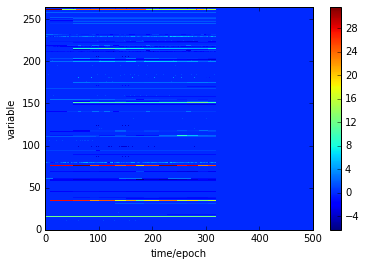

In [46]:
# figure out how many encounters we have
numencnt = X_train.shape[0]

# choose a random patient encounter to plot
ix = 400#Try a few different index values between 0 and 4999

# plot a matrix of observation values
plt.pcolor(np.transpose(X_train[ix,:,:]))
plt.ylabel("variable")
plt.xlabel("time/epoch")
plt.ylim(0,265)
plt.colorbar()
plt.show()

これらのデータは```sequence.pad_sequences```でゼロパディングがなされていることに注意してください。
0から4999までのいろいろなインデックス値で試してみて、行列散布図がどのように見えるか確認しましょう。
これらの行列は、LSTMモデルのトレーニングのために入力されるものです。
第1軸の代わりに、第3軸についてインデックスを指定することで、変数についても同様のプロットを行うことができます。これで、全ての患者についての特定の変数を眺めることができます。試してみてください！

## リカレントニューラルネットワークのモデル

リカレントニューラルネットワーク ([RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network))は、フィードバック機構を持った、伝統的なフィードフォワード型のネットワークです。
従来のフィードフォワード型ネットワークでは、全ての入力が独立しているとみなされます。
しかし、RNNへの入力には、以前の出力状態が含まれています。
これにより、RNNは非常に複雑な入力のシーケンスをモデル化することができます。また、RNNは[チューリング完全](https://en.wikipedia.org/wiki/Turing_completeness)であることが示されています。詳しくは[こちら](http://binds.cs.umass.edu/papers/1995_Siegelmann_Science.pdf)をご覧ください。
<img src="images/rnn.jpg" width="500">
<p style="text-align: center;">*image credit: wildml.com*</p>

RNNは、理論的には任意の長さのシーケンスを情報として利用することができますが、実際は[*勾配消失問題*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)に備えて、わずかなステップのみを振り返るように制限します。
そうしなければ、
トレーニングを行っている間、誤差が時間を通じて逆伝播するにつれて、以前の時間ステップからの入力は指数関数的に減少し、最終的にはゼロ（すなわち、消失）になってしまいます。

RNNには、[Long Short Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory)と呼ばれる変種があります。これは、1997年に [Hochreiter と Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf)によって発表されました。
LSTMには勾配消失問題がありません。
LSTMは通常、[忘却ゲート](http://www.jmlr.org/papers/volume3/gers02a/gers02a.pdf)と呼ばれる再帰ゲートによって拡張されています。
LSTMの定義上の特徴は、逆伝播する誤差が消失（あるいは爆発）してしまうのを防ぎます。時間内に展開される無数の"仮想レイヤー"を通して、誤差を逆伝播させることを可能にするのです。
すなわち、LSTMは数百万ステップも前に起こった事象を記憶しておく必要のある、"[非常に深い](https://arxiv.org/abs/1404.7828)"タスクを学習することができるのです。
LSTMのような、問題に特化したネットワークのトポロジーは、長い遅延が含まれていたり、低周波数成分と高周波成分が混ざっていたりする信号に対しても機能する可能性があり、さらに進化する可能性があるのです。

それでは、データを取り込んで、各時間ステップで患者の生存確率を予測するために、RNNを構築していきます。
以下の図は```Keras```を使って構築されたモデルの概要を示しています。

<img src="images/drted_rnn.svg" width="800">


各時間ステップにおいて、記録された測定値が入力され、生存の予測確率が生成されます。
これにより、患者の動向や生存確率をリアルタイムでモニタリングすることができるのです。

### KerasによるLSTMネットワークの構築
[Keras](https://keras.io) は、Pythonで書かれた、モジュール式のニューラルネットワークライブラリで、[TensorFlow](https://www.tensorflow.org) または [Theano](http://deeplearning.net/software/theano/)の上で動作します。
ここでは、一般的なRNNやLSTMの扱いに優れているTheanoを使用することに興味があります。

[Caffe](http://caffe.berkeleyvision.org)のように、いくつかのフレームワークはRNNをサポートしていません。
Kerasは、手早い実験を可能にすることに焦点を当てて開発されました。
アイデアを結果にするまでの時間を最小限にすることは、良い研究をする上で重要です。

Kerasのライブラリはソリューションの試作を容易にし、畳み込みネットワークとリカレントネットワーク、そしてその組み合わせもサポートしています。
さらに、任意の接続方式（多入力と多出力のトレーニングを含む）もサポートしています。
そして、```Keras```はCPUまたはGPU上で動作し、Python 2.7-3.5に対応しています。

In [47]:
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model
from keras.optimizers import RMSprop

# Note: building model using Keras Functional API (version > 1.0)

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout_W': 0.25, 'dropout_U': 0.1, 'return_sequences': True, 'consume_less': 'gpu'}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(input=x, output=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, 265)     0                                            
____________________________________________________________________________________________________
input_masked (Masking)           (None, None, 265)     0           input[0][0]                      
____________________________________________________________________________________________________
lstm1 (LSTM)                     (None, None, 128)     201728      input_masked[0][0]               
____________________________________________________________________________________________________
output (TimeDistributed)         (None, None, 1)       129         lstm1[0][0]                      
Total params: 201857
______________________________________________________________________

### モデル設計の際の決定事項

ここでは、単一のLSTMを作成しました。
 
2値分類問題（ここでは死亡率）における最適なコスト関数であるため、*Binary cross entropy loss function* 　を使用します。
ただし、平均二乗誤差（MSE）が使われることもあります。数値的に少し安定する傾向があるためです。

*Dropout W* は、入力ベクトルの要素をランダムに欠落させるために使用します。各シーケンスの時間ステップ毎に、ベクトルの同じ要素を欠落させます。
これは、ネットワークが共変量変数の情報を利用するように強制します。たとえば、ある心拍数のサンプルが‘欠落’した場合でも、血圧と呼吸数の組み合わせが代わりになってくれるのです。
 
*Dropout U* は、CNNにおける伝統的なドロップアウトと同様の理由で使用されます。ネットワークに全ての隠れノードを利用するようにし、あまりにも多くの情報が単一の隠れノードに含まれないようにするのです。実際、これにより安定したネットワークが学習される傾向があります。
 
*RMSprop* オプティマイザは、LSTMの一般的なオプティマイザであるため選択されています。詳細は[こちら](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)をご覧ください。
 
*LR=0.005* は、少ないエポック数で妥当な局所最小値を見つけるために設定されています。一般的には、LRを小さくするほどネットワークの‘学習ステップ’が小さくなりますが、そのかわりに収束までのトレーニング時間が長くなってしまいます。
 
ニューラルネットワークにはいつものように、多少のハイパーパラメータチューニングが必要でした。このネットワークは最適に調整されているわけではありません。ここではチュートリアルのため、最小限のGPUで最高の死亡率予測器を作成するために、ほんの少しの妥当な値が選択されています。


Kerasにおける core layers に関しては、 [こちらのドキュメント](https://keras.io/layers/core/)を参照してください。

では、ネットワークにいくつかのデータを与えてトレーニングを行いましょう。バッチサイズは128、つまり、128個のデータ毎にパラメータを更新します。
デモンストレーションとして、トレーニングエポックは5としておきましょう。つまり、データを5回ほど周回して学習します。
verboseオプションでは、トレーニング中にステータスと要約情報を生成するかどうかを指定できます。

In [48]:
# this will take a while...
history = model.fit(X_train, y_train, batch_size=128, nb_epoch=5, verbose=1)

Epoch 1/5
5000/5000 [==============================] - 18s - loss: 0.2679    
Epoch 2/5
5000/5000 [==============================] - 17s - loss: 0.2195    
Epoch 3/5
5000/5000 [==============================] - 17s - loss: 0.1968    
Epoch 4/5
5000/5000 [==============================] - 17s - loss: 0.1888    
Epoch 5/5
5000/5000 [==============================] - 17s - loss: 0.1903    


### モデルの評価とベースラインとの比較

モデルの性能を評価する際の最初の仕事は、ホールドアウトデータセット（検証データ）を用いて死亡率を予測することです。

In [49]:
# generate RNN results on holdout validation set
preds = model.predict(X_valid)

予測結果のサイズを見てみましょう。

In [50]:
preds.shape

(2690, 500, 1)

これはつまり、テスト用の2690人の患者データがあり、それぞれの観測において生存率が予測されます。いくつかの予測をプロットしてみましょう！

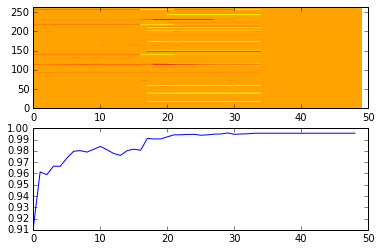

In [51]:
# figure out how many encounters we have
numencnt = X_valid.shape[0]

# choose a random patient encounter to plot
ix = random.randint(0,numencnt-1)

# create axis side by side
f, (ax1, ax2) = plt.subplots(2, 1)

# plot the obs chart for patient encounter
ax1.pcolor(np.transpose(X_valid[ix,1:50,:]))
ax1.set_ylim(0,265)

# plot the patient survivability prediction
ax2.plot(preds[ix,1:50]);

## ベースライン手法との比較: PRISM3 and PIM2.

PIM2とPRISM3はいずれも、ICUおよび外科患者のスコアリングシステムです。

集中治療に入った患者群の死亡リスクを予測するモデルは、成人、小児および新生児集中治療に利用できます。
重症度と診断の差を調整することにより、これらのモデルを用いて、治療室間あるいは治療室内のケアの基準を比較することができます。
それらは、集中治療の計画方法を比較するためにも利用できます。死亡リスクを推定することは、実験における患者群比較の重要な要素でもあります。

Pediatric Index of Mortality (PIM) は当初、集中治療室への入院時に収集された変数を必要とする、単純なモデルとして開発されました。
オリジナルのPIMは、主にオーストラリアの治療室で開発されました。最初の報告では、イギリスにおける8つの治療室のうち、ただ1つのみが利用可能でした。
PIM2は、14の集中治療室における最近のデータセットによって修正された死亡率指数です。14のうち8つがオーストラリアで、4つがイギリス、2つがニュージーランドです。
PIM2の分析には、16歳未満の小児患者20,787名の入院が含まれていました。
PIM2は、ICU入院時にすぐに得られるデータから死亡率を推定するので、小児集中治療の継続的なモニタリングをするのに適しています。
PIM2は、最初のコンタクトからICU到着後1時間までの間に測定された各変数の、最初の値を利用します。
情報が欠落している場合（たとえば、塩基過剰が測定されていない場合）、PIM2はゼロを記録します。ただし、収縮期血圧については、ゼロではなく120と記録されます。
連続する全ての入院が含まれています。
詳細については、[Slater et al.](https://www.ncbi.nlm.nih.gov/pubmed/12541154)をご覧ください。

同様に、Pediatric Risk of Mortality ([PRISM](http://www.ncbi.nlm.nih.gov/pubmed/3048900))スコアは1988年頃、Physiologic Stability Index ([PSI](http://www.ncbi.nlm.nih.gov/pubmed/6728571))をもとに開発されました。具体的には、小児ICU死亡リスク評価に必要な変数の種類を、PSIにおける34から14へと減らし、それらの客観的な重み付けを得るようになっています。
<a href="http://www.jpeds.com/article/S0022-3476(97)70065-9/abstract">PRISM3</a>は、1996年に発表された最新のスコアリングシステムで、元のモデルよりいくらか改善された点があります。
ただし、ライセンスのもとでのみ利用可能であり、米国以外では広く利用されていません。
PRISM3スコアは、26分割された17種類の生理学的変数を有します。
死亡率を最も予測する変数として認められたのは、最低収縮期血圧、瞳孔反射異常、昏睡でした。

まず、予測のための[ROC](http://gim.unmc.edu/dxtests/roc2.htm)情報を計算します。

In [52]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary lable for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

次に、事前にCSVファイルから計算されたPIM2とPRISM3の推定値を抽出します。

In [53]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# load the scores and then compute the ROC curves and AUC
index = pd.read_csv(os.path.join(data_dir, 'pim2prism3.csv'))

# get the mortality reponse for each patient
mortrep = index['mortalityResponse'];

# generate ROC curves for each index
pim2_roc   = roc_curve(mortrep, -index['PIM2'  ])
prism3_roc = roc_curve(mortrep, -index['PRISM3'])

# compute the area under the curve for each index
pim2_auc   = auc(  pim2_roc[0],   pim2_roc[1])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

比較のために、これらのROC曲線をRNNの結果とともにプロットしましょう。

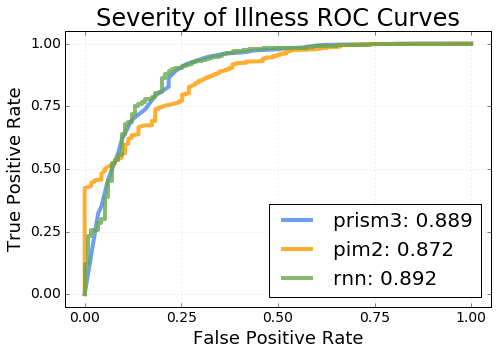

In [54]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

私達がトレーニングを数回しか行っていないことを考慮すれば、これはどんなに良い結果といえるでしょうか！

## まとめ
RNNは、利用可能なEHRデータから、臨床的に重要な情報と洞察を迅速に抽出する方法を提供します。

このチュートリアルでは計算量を軽減するために、データ量とモデルの複雑さ、特徴量の数、エポック数を減らしました。
以下に表示されている例は、より大きなデータセットのもとで十分に訓練されたRNNによるパフォーマンスです。
標準的なスコアリングシステムであるPIM2とPRISM3に加え、ロジスティック回帰と多層パーセプトロンによるパフォーマンスも表示してあります。

RNNのもつ時間的ダイナミクスは、MLPよりも多くの情報をEHRから抽出することを可能にします。
MLPの複雑さはRNNと同様ですが、前者は瞬間的な情報に限られているのです。

<img src="images/RNN_performance.svg" width="500" height="500">

下の図は、十分に訓練されたRNNによる生存確率予測の、時間的な軌跡を表しています。任意のタイムステップで予測する能力は、臨床医が治療決定の影響を評価するための、貴重なフィードバックを提供します。

<img src="images/MortalityThroughTime.svg" width="500" height="500">


## Discovery Requires Experimentation
ここでは、実験設定に関するいくつかのアイデアを紹介します。これらの変更は、トレーニングとパフォーマンスにどのような影響を与えるでしょうか？
1. ネットワークに、2番目と3番目のLSTMレイヤを追加しましょう。 
2. 層の数や、それらの層におけるニューロンの数を変更しましょう。
3. ドロップアウトや学習率など、ネットワークのハイパーパラメータを変更するのはどうでしょうか？
4. [宿題] CNNを試してみましょう。  RNN/LSTMモデルは通常のCNNモデルを上回るでしょうか？
5. [考えるべきこと] このデータセットは負例（死亡例）が少なすぎるのではないでしょうか？ ICUの生存率は96%です。これはトレーニングにどのような影響を与えるでしょうか？